This notebooks goal is to auto calculate all the metrics (velocity and position) that were used in my original definitions.  This is because I've noticed some discrepencies where I don't think there should be, and this might be due to human error in picking values manually, copying over to a spreadsheet, or just because the data was slightly altered/added to to increase the number of valid sequences for the new definition.

Either way, I think its worth it to recalculate it all algorithmically instead of with human intervention|

In [1]:
import graphing as g
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


In [2]:
full_list_seq =  ['AC01_04',
            'AC01_05',
            'AC01_06',
            'AC01_10',
             
            'AC03_04',
            'AC03_06',
            'AC03_09',
            'AC03_14',
            'AC03_15',
            'AC03_18',
            'AC03_20',
            'AC03_21',
            'AC03_22',
            'AC03_23',
             
            'AC04_03']

In [19]:
data.keys()

dict_keys(['mntx', 'mnta', 'elly', 's_mnty', 'ellx', 'fn', 'ella', 's_mnta', 'FL_a', 'time', 'ellw', 'mnty', 'fps', 'FL_t', 'frogsize(cm)', 'HL_t', 's_mntx', 'HL_a', 'height', 'o_mnty', 'ellh', 'pxSVL', 'watercontactIdx', 'width', 'waterlevel', 'frameno'])

In [3]:
def above_below_water_range(data, jmp_strict_def = False):
    above = []
    below = []
    #these are the index of water contact
    wc_idx = data['watercontactIdx'][0].flatten()
    #we want to auto-generate each range and check if it the y value > 0
    ####print(wc_idx, len(wc_idx))
    
    #jmp_strict_def if True will only return the ranges included in the
    # strinct jump definition (HL_a to HL_a)
    if jmp_strict_def:
        [(HL_a_fr_s, _), (HL_a_fr_end, _)] = data['HL_a']
        HL_a_idx_start = list(data['frameno']).index(HL_a_fr_s)
        HL_a_idx_end = list(data['frameno']).index(HL_a_fr_end)
        ##print(HL_a_idx_start, HL_a_idx_end)
    
    for i in range(len(wc_idx) + 1):
        ##print(i)
        if i == 0: #first value
            startidx = 0
            endidx = wc_idx[i]
        elif i == (len(wc_idx)):# last value
            startidx = wc_idx[i-1]
            endidx = -1
        else: #middle value
            startidx = wc_idx[i-1]
            endidx = wc_idx[i]
        thesum= np.sum(data['s_mnty'][startidx:endidx])
        ##print('%d:%d --- %s' %(startidx, endidx, thesum > 0))
        
        if jmp_strict_def:
            #Before the segment, skip this range:
            if endidx < HL_a_idx_start:
                continue
            #After the segnebtm skip this rangeL
            if startidx > HL_a_idx_end:
                continue
            if startidx < HL_a_idx_start:
                startidx = HL_a_idx_start
            if endidx > HL_a_idx_end:
                endidx = HL_a_idx_end
               
        if thesum > 0:
            above += [(startidx, endidx)]
        else:
            below += [(startidx, endidx)]
    return above, below

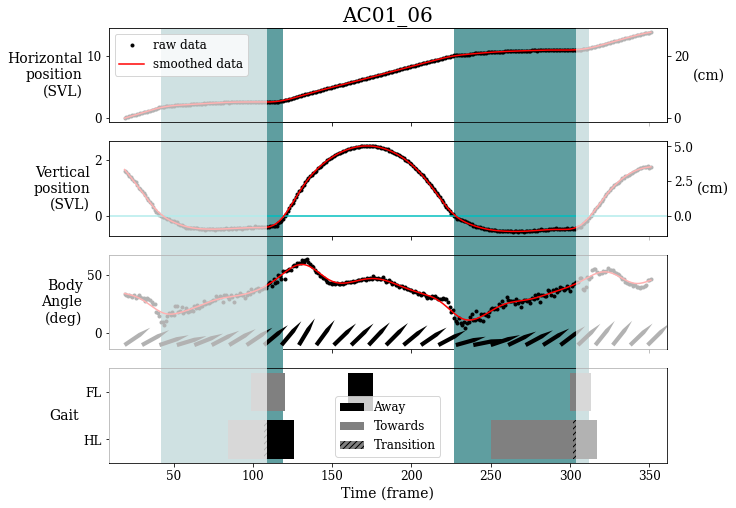

In [4]:
# AC01_06 is a good test because there are 3 jumps in it
ax, fig = g.graph_all('AC01_06', 'frame', (10, 8), segment=True)

In [5]:
data = g.loadSingleFrog_wsmoothed('AC01_04')
above, below = above_below_water_range(data)

In [6]:
above

[(0, 98), (143, -1)]

In [7]:
below

[(98, 143)]

In [8]:
#determining the 3 types of jump for each jump: end (water landing only),
# start (water exit only) or full (water exit to entrance)
def define_jump_ranges(data):
    #get the above water, below water ranges
    above, below = above_below_water_range(data)
    
    jumps = {}
    
    #now to split into jumps.  Each jump is a water exit -> waer entrance
    for i, below_range in enumerate(below):
        below_start, below_end = below_range
        cor_above_s, cor_above_e = above[i]
        #want to know if that above sequence before or after the below sequence
        if cor_above_e == below_start:
            #this means that the above is before the below seq, and the first jump\
            # is the above seq
            if i not in jumps.keys():
                jumps[i] = {}
            if i+1 not in jumps.keys():
                jumps[i+1] = {}
            jumps[i]['above'] = above[i]
            jumps[i+1]['below'] = below_range
        elif cor_above_s == below_end:
            #this means that the above sequence is after the below sequence
            jumps[i] = {'above':above[i], 'below':below_range}
    if len(above)>len(below):
        #print('here')
        cor_above_s, cor_above_e = above[i+1]
        if cor_above_s == below_end:
            #there is one more above seq then below - this is another jump
            jumps[i+1]['above'] = above[i+1]
        
    return jumps

In [9]:
define_jump_ranges(data)

{0: {'above': (0, 98)}, 1: {'below': (98, 143), 'above': (143, -1)}}

In [10]:
for frog in full_list_seq:
    data = g.loadSingleFrog_wsmoothed(frog)
    ranges = define_jump_ranges(data)
    print('%s : %d jumps' %(frog, len(ranges.keys())))
    print(ranges)
    print('\n')      

AC01_04 : 2 jumps
{0: {'above': (0, 98)}, 1: {'below': (98, 143), 'above': (143, -1)}}


AC01_05 : 2 jumps
{0: {'above': (12, 110), 'below': (0, 12)}, 1: {'above': (164, -1), 'below': (110, 164)}}


AC01_06 : 3 jumps
{0: {'above': (0, 23)}, 1: {'below': (23, 100), 'above': (100, 208)}, 2: {'below': (208, 293), 'above': (293, -1)}}


AC01_10 : 3 jumps
{0: {'above': (0, 10)}, 1: {'below': (10, 127), 'above': (127, 174)}, 2: {'below': (174, 216), 'above': (216, -1)}}


AC03_04 : 2 jumps
{0: {'above': (21, 75), 'below': (0, 21)}, 1: {'above': (103, -1), 'below': (75, 103)}}


AC03_06 : 2 jumps
{0: {'above': (0, 45)}, 1: {'below': (45, 77), 'above': (77, 124)}}


AC03_09 : 1 jumps
{0: {'above': (13, -1), 'below': (0, 13)}}


AC03_14 : 3 jumps
{0: {'above': (0, 56)}, 1: {'below': (56, 213), 'above': (213, 293)}, 2: {'below': (293, -1)}}


AC03_15 : 2 jumps
{0: {'above': (50, 146), 'below': (0, 50)}, 1: {'above': (233, -1), 'below': (146, 233)}}


AC03_18 : 2 jumps
{0: {'above': (29, 119), 'b

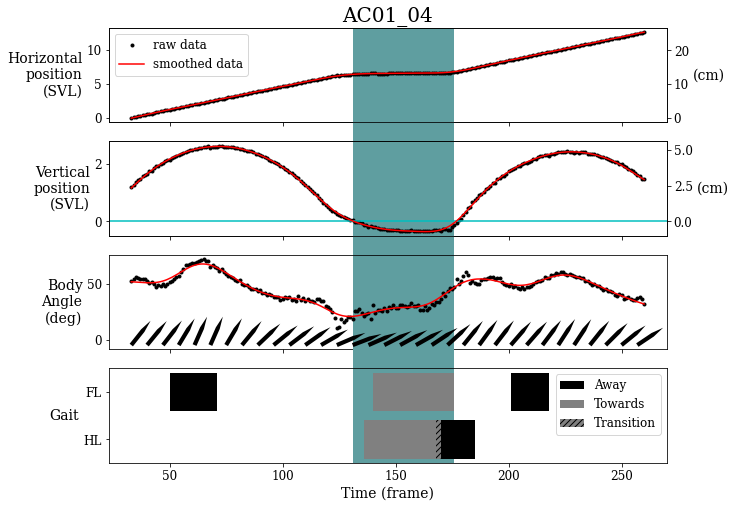

In [11]:
ax, fig= g.graph_all('AC01_04', 'frame', (10, 8), segment=False)

In [12]:
#OK lets automate this shit, these jump segmentations look good

In [13]:
frog = 'AC01_04'

data = g.loadSingleFrog_wsmoothed(frog)
ranges = define_jump_ranges(data)
no_jumps = len(ranges.keys())

def range2frame(jmp): return [(data['frameno'][x], data['frameno'][y]) for (x, y) in jmp]



s_mnty = data['s_mnty']
s_mntx = data['s_mntx']
s_mnta = data['s_mnta']

#go through each jump:
for jmp in range(no_jumps):
    jmp_dict = ranges[jmp]
    
    eachJmpDict = {}
    
    #     #get amount of jump:
    #     if 'above' in jump_dict.keys():
    #         if 0 in jump_dict['above'] or -1 in jump_dict['above']:
    #             #Then it is partial

    #         else: #it contains full section


    #     if'below' in jump_dict.keys()
    #         if 0 in jump_dict['below'] or -1 in jump_dict['below']:
    #             #Then it is partial
    #         else: #it contains full section
            
            
    #Ok lets list all the metrics we are calculating here
    #sequence id
    #jump number
    eachJmpDict['jmpNo'] = jmp + 1
    #fps
    eachJmpDict['fps'] = data['fps']
    #px/SVL
    eachJmpDict['px/SVL'] = data['pxSVL']
    
    
    #frame start of jump (water exit)
    #frame water land
    ##############
    #if only have above or below:
    #     if above --> landing frame is the non 0/-1 --> first jump --> above[1]
    #     if below --> launching frame is the non 0/-1 --> last jmp --> below[0]
    #if full jump (both above and below)
    #     above[0] = below[1] = launch
    #     above[1] = land
    if len(jmp_dict.keys()) == 1:
        if 'above' in jmp_dict.keys():
            frameWaterLand = data['frameno'][jmp_dict['above'][1]]
            frameWaterExit = None
        if 'below' in jmp_dict.keys():
            if jmp_dict['below'][1] != -1:
                frameWaterExit = data['frameno'][jmp_dict['below'][1]]
            else:
                frameWaterExit = None
            frameWaterLand = None
    else: #there should be an above and below
        frameWaterLand = data['frameno'][jmp_dict['above'][1]]
        frameWaterExit = data['frameno'][jmp_dict['above'][0]]
    
    eachJmpDict['frameWaterLand'] = frameWaterLand
    eachJmpDict['frameWaterExit'] = frameWaterExit
  
    print(frameWaterLand, frameWaterExit)
    
    #-----amount of jump?
    #jump contains max height
    ###### always true if above does not contain 0/-1
    ###### if it does: need to check for inflection point:
    ######

    #actual height (px)
    #actual range (px)
    #fit height (px)
    #fit range (px)
    ### 'jmpHasMaxHeight', 'AboveWaterActualHeight_px',  'AboveWaterActualRange_px', 
    ###  'AboveWaterFitHeight_px', 'AboveWaterFitRange_px', 

    
    s_mnty = data['s_mnty']
    s_mntx = data['s_mntx']
    s_mnta = data['s_mnta']
    ##ranges = define_jump_ranges(data) <-- jmp_dict
    
    ##this only happens IF there is an above section
    if 'above' in jmp_dict.keys():
        jmpfit = np.polyfit(s_mntx[slice(*jmp_dict['above'])], s_mnty[slice(*jmp_dict['above'])], 2)
        jmpfitpoly = np.poly1d(jmpfit)
        #print(jmpfitpoly.deriv().roots)
        zerocross = jmpfitpoly.roots
        print(zerocross)
        theinflect = jmpfitpoly.deriv().roots[0]


        maxrange = np.max(s_mntx[slice(*jmp_dict['above'])])
        minrange = np.min(s_mntx[slice(*jmp_dict['above'])])


        if maxrange > theinflect > minrange:
            print('idx @ Max Height = %f' %theinflect)
            print('max Height = %f' %(np.max(s_mnty[slice(*jmp_dict['above'])])))
            eachJmpDict['AboveWaterActualHeight_px'] = np.max(s_mnty[slice(*jmp_dict['above'])])
            eachJmpDict['jmpHasMaxHeight'] = True
            print('Fit Height = %f' %jmpfitpoly(theinflect))
            eachJmpDict['AboveWaterFitHeight_px'] = jmpfitpoly(theinflect)

            #Check - is there a water contact idx at the end of the jump
            if -1 not in jmp_dict['above'] and 0 not in jmp_dict['above']:

                print('max Range = %f' %(s_mntx[jmp_dict['above'][1]] - s_mntx[jmp_dict['above'][0]]))
                eachJmpDict['AboveWaterActualRange_px'] = s_mntx[jmp_dict['above'][1]] - s_mntx[jmp_dict['above'][0]]
            else: 
                print('max Range = NONE')
                eachJmpDict['AboveWaterActualRange_px'] = None
            print('Fit Range = %f' %(zerocross[0] - zerocross[1]))
            eachJmpDict['AboveWaterFitRange_px'] = zerocross[0] - zerocross[1]


        #plt.plot(s_mntx[slice(*ranges[jmpno]['above'])], jmpfitpoly(s_mntx[slice(*ranges[jmpno]['above'])]), 'k-', label='fit')
        #plt.plot(s_mntx[slice(*ranges[jmpno]['above'])], s_mnty[slice(*ranges[jmpno]['above'])], 'r.', label='smoothed data')

    else:
        #no max/fit range or max/fit height
        eachJmpDict['AboveWaterActualHeight_px'] = None
        eachJmpDict['jmpHasMaxHeight'] = False
        eachJmpDict['AboveWaterFitHeight_px'] = None
        eachJmpDict['AboveWaterActualRange_px'] = None
        eachJmpDict['AboveWaterFitRange_px'] = None
        
        
    #body angle @ WC launch
    #body angle @ WC land
    ##### We already determined if this jump has launch/land
    if eachJmpDict['frameWaterLand'] is not None: #meaning if not None - exists
        eachJmpDict['BAatWC_land'] = s_mnta[jmp_dict['above'][1]]
    else:
        eachJmpDict['BAatWC_land'] = None
    if eachJmpDict['frameWaterExit'] is not None: #meaning if not None  -exists
        eachJmpDict['BAatWC_launch'] = s_mnta[jmp_dict['below'][0]]
    else:
        eachJmpDict['BAatWC_launch'] = None

    def HL_in_range(x, r): return any(map(lambda r: x in range(*r), range2frame(r)))

    #frame start propulsion
    #frane end propulsion
    #propulsion time (frames)
    for HL_test in data['HL_a']:
        start, dur = HL_test
        if HL_in_range(start, jmp2):
            break
        else:
            start = None
            dur = None
    eachJmpDict['framePropStart'] = start
    eachJmpDict['frameDurationProp'] = dur


    #frame start preparation
    #frame end preparation
    #duration of preparation (frames)
    for HL_test in data['HL_t']:
        start, dur = HL_test
        if HL_in_range(start, jmp2):
            break
        else:
            start = None
            dur = None
    
    eachJmpDict['framePrepStart'] = start
    eachJmpDict['frameDurationPrep'] = dur

    #wait time (btw WC land and prep start)

    #horizontal distance below WS after jump (px) (this will refer to the below section of jmp+1)
    ####something like a 'coast' distance?
    ## OK - first -> is there a next jump?
    if (jmp + 1) in range(no_jumps):
        #yes - make sure there is an exit for that jump? same as if there is an above section at least a littler
        if 'above' in ranges[jmp +1].keys():
            eachJmpDict['BelowWaterRange_after_px'] = s_mntx[ranges[jmp+1]['below'][1]] - s_mntx[ranges[jmp+1]['below'][0]]
        else:
            eachJmpDict['BelowWaterRange_after_px'] = None                                                                                        
    #no
    else:
        eachJmpDict['BelowWaterRange_after_px'] = None
    print(eachJmpDict['BelowWaterRange_after_px'])
    
    #max vertical distance below WS before jump (px) - this is this jumps before
    if eachJmpDict['frameWaterExit'] is not None: 
        eachJmpDict['MaxHeightBelowWater_before_px'] = np.max(-1*s_mnty[slice(*jmp_dict['below'])])
    else:
        eachJmpDict['MaxHeightBelowWater_before_px'] = None

    #avg underwater angle before jump
    ##only includes sequences with water enter/exit:
    if 'below' in jmp_dict.keys():
        if 0 not in jmp_dict['below'] and -1 not in jmp_dict['below']:
            eachJmpDict['AVG_BelowWater_BA_before'] = np.mean(s_mnta[slice(*jmp_dict['below'])])
    else:
        eachJmpDict['AVG_BelowWater_BA_before'] = None
    #avg above water angle during jump
    if 'above' in jmp_dict.keys():
        if 0 not in jmp_dict['above'] and -1 not in jmp_dict['above']:
            eachJmpDict['AVG_AboveWater_BA'] = np.mean(s_mnta[slice(*jmp_dict['below'])])
    else:
        eachJmpDict['AVG_AboveWater_BA'] = None


    #########VELOCITIES##############
    #idx of Max Vel
    #frame of max vel
    #Vx at max Vel (px/sec)
    #Vy @ max vel (px/sec)
    #V @ max vel (px/sec)
    #V angle @ max V
    #body angle @ max V

    #avg horizontal velocity above WS (px/sec)
    #avg horizontal velcity below WS AFTER JUMP (px/sec) - like coast velocity - this is before jump + 1
    #avg horizontal velocity total (launch + land coast)
    ### ============== CHECK - DURING PROP/PREP, WHAT VERT/HOR DISTANCE MOVED?

        

131 None
[600.55822391 -89.63312629]
idx @ Max Height = 255.462549
max Height = 245.848349
Fit Height = 245.273506
max Range = NONE
Fit Range = 690.191350


NameError: name 'jmp2' is not defined

In [61]:
sprdsht = pd.DataFrame(columns = ['ID', 'jmpNo', 'frog', 'fps', 'SVL(cm)', 'px/SVL', 
                                 'frameWaterExit','frameWaterLand', 
                                 'frameDurationAboveWater', 'secDurationAboveWater',
                                 'jmpHasMaxHeight',
                                 'AboveWaterActualHeight_px','AboveWaterActualHeight_cm',
                                 'AboveWaterActualRange_px', 'AboveWaterActualRange_cm',
                                 'AboveWaterFitHeight_px', 'AboveWaterFitHeight_cm',
                                 'AboveWaterFitRange_px', 'AboveWaterFitRange_cm',
                                 'BAatWC_launch','BAatWC_land', 
                                 'framePropStart', 'frameDurationProp', 'secDurationProp',
                                 'framePrepStart','frameDurationPrep', 'secDurationPrep',
                                 'frameDurationWait', 'secDurationWait',
                                 'BelowWaterRange_after_px', 'BelowWaterRange_after_cm',
                                 'MaxHeightBelowWater_before_px', 'MaxHeightBelowWater_before_cm',
                                 #'MaxHeightBelowWater_after_px', 
                                 'AVG_BelowWater_BA_before', 
                                 'AVG_AboveWater_BA',
                                 #'AVG_BelowWater_BA_after' 
                                 ])

In [62]:
len(list(eachJmpDict.keys()))

12

In [63]:
def get_position_stats_dict_old_def(frog_ID):
    data = g.loadSingleFrog_wsmoothed(frog_ID)


    ranges = define_jump_ranges(data)
    no_jumps = len(ranges.keys())

    def range2frame(jmp): return [(data['frameno'][x], data['frameno'][y]) for (x, y) in jmp]

    frog_dict = {}

    s_mnty = data['s_mnty']
    s_mntx = data['s_mntx']
    s_mnta = data['s_mnta']

    #go through each jump:
    for jmp in range(no_jumps):
        jmp_dict = ranges[jmp]

        eachJmpDict = {}

        #     #get amount of jump:
        #     if 'above' in jump_dict.keys():
        #         if 0 in jump_dict['above'] or -1 in jump_dict['above']:
        #             #Then it is partial

        #         else: #it contains full section


        #     if'below' in jump_dict.keys()
        #         if 0 in jump_dict['below'] or -1 in jump_dict['below']:
        #             #Then it is partial
        #         else: #it contains full section


        #Ok lets list all the metrics we are calculating here
        #sequence id
        #jump number
        eachJmpDict['jmpNo'] = jmp + 1
        #fps
        eachJmpDict['fps'] = data['fps']
        #px/SVL
        eachJmpDict['px/SVL'] = data['pxSVL']
        #SVLcm
        eachJmpDict['SVL(cm)'] = data['frogsize(cm)']


        #frame start of jump (water exit)
        #frame water land
        ##############
        #if only have above or below:
        #     if above --> landing frame is the non 0/-1 --> first jump --> above[1]
        #     if below --> launching frame is the non 0/-1 --> last jmp --> below[0]
        #if full jump (both above and below)
        #     above[0] = below[1] = launch
        #     above[1] = land
        if len(jmp_dict.keys()) == 1:
            #first jump only
            if 'above' in jmp_dict.keys():
                if jmp_dict['above'][0] != 0:
                    frameWaterExit = data['frameno'][jmp_dict['above'][0]]
                    frameWaterLand = data['frameno'][jmp_dict['above'][1]]
                else:
                    frameWaterLand = data['frameno'][jmp_dict['above'][1]]
                    frameWaterExit = None
            #last jump only
            if 'below' in jmp_dict.keys():
                if jmp_dict['below'][1] !=-1:
                    frameWaterExit = data['frameno'][jmp_dict['below'][1]]
                else:
                    frameWaterExit = None
                frameWaterLand = None
        else: #there should be an above and below
            #again need to check if each range is cut off
            if jmp_dict['above'][1] != -1:
                frameWaterLand = data['frameno'][jmp_dict['above'][1]]
            else:
                frameWaterLand = None
            if jmp_dict['above'][0] !=0:    
                frameWaterExit = data['frameno'][jmp_dict['above'][0]]
            else:
                frameWaterExit = None

        eachJmpDict['frameWaterLand'] = frameWaterLand
        eachJmpDict['frameWaterExit'] = frameWaterExit
        try:
            eachJmpDict['frameDurationAboveWater'] = eachJmpDict['frameWaterLand'] - eachJmpDict['frameWaterExit']
            eachJmpDict['secDurationAboveWater'] = eachJmpDict['frameDurationAboveWater']/data['fps']
        except:
            eachJmpDict['frameDurationAboveWater'] = None
            eachJmpDict['secDurationAboveWater'] = None
        #print(frameWaterLand, frameWaterExit)

        #-----amount of jump?
        #jump contains max height
        ###### always true if above does not contain 0/-1
        ###### if it does: need to check for inflection point:
        ######

        #actual height (px)
        #actual range (px)
        #fit height (px)
        #fit range (px)
        ### 'jmpHasMaxHeight', 'AboveWaterActualHeight_px',  'AboveWaterActualRange_px', 
        ###  'AboveWaterFitHeight_px', 'AboveWaterFitRange_px', 


        s_mnty = data['s_mnty']
        s_mntx = data['s_mntx']
        s_mnta = data['s_mnta']
        ##ranges = define_jump_ranges(data) <-- jmp_dict

        ##this only happens IF there is an above section
        if 'above' in jmp_dict.keys():
            jmpfit = np.polyfit(s_mntx[slice(*jmp_dict['above'])], s_mnty[slice(*jmp_dict['above'])], 2)
            jmpfitpoly = np.poly1d(jmpfit)
            #print(jmpfitpoly.deriv().roots)
            zerocross = jmpfitpoly.roots
            #print(zerocross)
            theinflect = jmpfitpoly.deriv().roots[0]


            maxrange = np.max(s_mntx[slice(*jmp_dict['above'])])
            minrange = np.min(s_mntx[slice(*jmp_dict['above'])])


            if maxrange > theinflect > minrange:
                #print('idx @ Max Height = %f' %theinflect)
                #print('max Height = %f' %(np.max(s_mnty[slice(*jmp_dict['above'])])))
                eachJmpDict['AboveWaterActualHeight_px'] = np.max(s_mnty[slice(*jmp_dict['above'])])
                eachJmpDict['AboveWaterActualHeight_cm'] = eachJmpDict['AboveWaterActualHeight_px']/eachJmpDict['px/SVL']*eachJmpDict['SVL(cm)']
                eachJmpDict['jmpHasMaxHeight'] = True
                #print('Fit Height = %f' %jmpfitpoly(theinflect))
                eachJmpDict['AboveWaterFitHeight_px'] = jmpfitpoly(theinflect)
                eachJmpDict['AboveWaterFitHeight_cm'] = eachJmpDict['AboveWaterFitHeight_px']/eachJmpDict['px/SVL']*eachJmpDict['SVL(cm)']

                #Check - is there a water contact idx at the end of the jump
                if -1 not in jmp_dict['above'] and 0 not in jmp_dict['above']:

                    #print('max Range = %f' %(s_mntx[jmp_dict['above'][1]] - s_mntx[jmp_dict['above'][0]]))
                    eachJmpDict['AboveWaterActualRange_px'] = s_mntx[jmp_dict['above'][1]] - s_mntx[jmp_dict['above'][0]]
                    eachJmpDict['AboveWaterActualRange_cm'] = eachJmpDict['AboveWaterActualRange_px']/eachJmpDict['px/SVL']*eachJmpDict['SVL(cm)']
                else: 
                    #print('max Range = NONE')
                    eachJmpDict['AboveWaterActualRange_px'] = None
                    eachJmpDict['AboveWaterActualRange_cm'] = None
                #print('Fit Range = %f' %(zerocross[0] - zerocross[1]))
                eachJmpDict['AboveWaterFitRange_px'] = zerocross[0] - zerocross[1]
                eachJmpDict['AboveWaterFitRange_cm'] = eachJmpDict['AboveWaterFitRange_px']/eachJmpDict['px/SVL']*eachJmpDict['SVL(cm)']
                
            else:
                eachJmpDict['AboveWaterActualHeight_px'] = None
                eachJmpDict['AboveWaterActualHeight_cm'] = None
                eachJmpDict['jmpHasMaxHeight'] = False
                eachJmpDict['AboveWaterFitHeight_px'] = None
                eachJmpDict['AboveWaterFitHeight_cm'] = None
                eachJmpDict['AboveWaterActualRange_px'] = None
                eachJmpDict['AboveWaterActualRange_cm'] = None
                eachJmpDict['AboveWaterFitRange_px'] = None
                eachJmpDict['AboveWaterFitRange_cm'] = None


            #plt.plot(s_mntx[slice(*ranges[jmpno]['above'])], jmpfitpoly(s_mntx[slice(*ranges[jmpno]['above'])]), 'k-', label='fit')
            #plt.plot(s_mntx[slice(*ranges[jmpno]['above'])], s_mnty[slice(*ranges[jmpno]['above'])], 'r.', label='smoothed data')

        else:
            #no max/fit range or max/fit height
            eachJmpDict['AboveWaterActualHeight_px'] = None
            eachJmpDict['AboveWaterActualHeight_cm'] = None
            eachJmpDict['jmpHasMaxHeight'] = False
            eachJmpDict['AboveWaterFitHeight_px'] = None
            eachJmpDict['AboveWaterFitHeight_cm'] = None
            eachJmpDict['AboveWaterActualRange_px'] = None
            eachJmpDict['AboveWaterActualRange_cm'] = None
            eachJmpDict['AboveWaterFitRange_px'] = None
            eachJmpDict['AboveWaterFitRange_cm'] = None


        #body angle @ WC launch
        #body angle @ WC land
        ##### We already determined if this jump has launch/land
        if eachJmpDict['frameWaterLand'] is not None: #meaning if not None - exists
            eachJmpDict['BAatWC_land'] = s_mnta[jmp_dict['above'][1]]
        else:
            eachJmpDict['BAatWC_land'] = None
        if eachJmpDict['frameWaterExit'] is not None: #meaning if not None  -exists
            eachJmpDict['BAatWC_launch'] = s_mnta[jmp_dict['below'][0]]
        else:
            eachJmpDict['BAatWC_launch'] = None

        def HL_in_range(x, r): return any(map(lambda r: x in range(*r), range2frame(r)))

        
        testjmp = list(jmp_dict.values())
        #frame start propulsion
        #frane end propulsion
        #propulsion time (frames)
        for HL_test in data['HL_a']:
            start, dur = HL_test
            if HL_in_range(start, testjmp):
                break
            else:
                start = None
                dur = None
        eachJmpDict['framePropStart'] = start
        eachJmpDict['frameDurationProp'] = dur
        try: eachJmpDict['secDurationProp'] = eachJmpDict['frameDurationProp']/eachJmpDict['fps']
        except: eachJmpDict['secDurationProp'] = None

        #frame start preparation
        #frame end preparation
        #duration of preparation (frames)
        for HL_test in data['HL_t']:
            start, dur = HL_test
            if HL_in_range(start, testjmp):
                break
            else:
                start = None
                dur = None

        eachJmpDict['framePrepStart'] = start
        eachJmpDict['frameDurationPrep'] = dur
        try: eachJmpDict['secDurationPrep'] = eachJmpDict['frameDurationPrep']/eachJmpDict['fps']
        except: eachJmpDict['secDurationPrep'] = None
            
#         try:   
#             eachJmpDict['frameDurationWait'] = eachJmpDict['frameWaterLand'] - eachJmpDict['framePrepStart']
#             eachJmpDict['secDurationWait'] = eachJmpDict['frameDurationWait']/eachJmpDict['fps']
#         except:
#             eachJmpDict['frameDurationWait'] = None
#             eachJmpDict['secDurationWait'] = None
    
        #wait time (btw WC land and prep start)

        #horizontal distance below WS after jump (px) (this will refer to the below section of jmp+1)
        ####something like a 'coast' distance?
        ## OK - first -> is there a next jump?
        if (jmp + 1) in range(no_jumps):
            #yes - make sure there is an exit for that jump? same as if there is an above section at least a littler
            if 'above' in ranges[jmp +1].keys():
                eachJmpDict['BelowWaterRange_after_px'] = s_mntx[ranges[jmp+1]['below'][1]] - s_mntx[ranges[jmp+1]['below'][0]]
                eachJmpDict['BelowWaterRange_after_cm'] = eachJmpDict['BelowWaterRange_after_px']/eachJmpDict['px/SVL']*eachJmpDict['SVL(cm)']
            else:
                eachJmpDict['BelowWaterRange_after_px'] = None  
                eachJmpDict['BelowWaterRange_after_cm'] = None
        #no
        else:
            eachJmpDict['BelowWaterRange_after_px'] = None
            eachJmpDict['BelowWaterRange_after_cm'] = None
        #print(eachJmpDict['BelowWaterRange_after_px'])

        #max vertical distance below WS before jump (px) - this is this jumps before
        if eachJmpDict['frameWaterExit'] is not None: 
            eachJmpDict['MaxHeightBelowWater_before_px'] = np.max(-1*s_mnty[slice(*jmp_dict['below'])])
            eachJmpDict['MaxHeightBelowWater_before_cm'] = eachJmpDict['MaxHeightBelowWater_before_px']/eachJmpDict['px/SVL']*eachJmpDict['SVL(cm)']
        else:
            eachJmpDict['MaxHeightBelowWater_before_px'] = None
            eachJmpDict['MaxHeightBelowWater_before_cm'] = None

        #avg underwater angle before jump
        ##only includes sequences with water enter/exit:
        if 'below' in jmp_dict.keys():
            if 0 not in jmp_dict['below'] and -1 not in jmp_dict['below']:
                eachJmpDict['AVG_BelowWater_BA_before'] = np.mean(s_mnta[slice(*jmp_dict['below'])])
            else:
                eachJmpDict['AVG_BelowWater_BA_before'] = None
        else:
            eachJmpDict['AVG_BelowWater_BA_before'] = None
        #avg above water angle during jump
        if 'above' in jmp_dict.keys():
            if 0 not in jmp_dict['above'] and -1 not in jmp_dict['above']:
                eachJmpDict['AVG_AboveWater_BA'] = np.mean(s_mnta[slice(*jmp_dict['above'])])
            else:
                eachJmpDict['AVG_AboveWater_BA'] = None
        else:
            eachJmpDict['AVG_AboveWater_BA'] = None
            
        frog_dict[jmp] = eachJmpDict    
        
    return frog_dict

In [59]:
sprdsht = pd.DataFrame(columns = ['ID', 'jmpNo', 'fps', 'px/SVL', 'frameWaterExit',
                                 'frameWaterLand', 'jmpHasMaxHeight',
                                 'AboveWaterActualHeight_px',
                                 'AboveWaterActualRange_px', 
                                 'AboveWaterFitHeight_px', 
                                 'AboveWaterFitRange_px', 
                                 'BAatWC_launch',
                                 'BAatWC_land', 'framePropStart', 'frameDurationProp',
                                 'framePrepStart', 
                                 'frameDurationPrep', 
                                 'BelowWaterRange_after_px', 
                                 'MaxHeightBelowWater_before_px', 
                                 #'MaxHeightBelowWater_after_px', 
                                 'AVG_BelowWater_BA_before', 
                                 'AVG_AboveWater_BA',
                                 #'AVG_BelowWater_BA_after' 
                                 ])

In [64]:
i = 0
for frog in full_list_seq:
    print(frog)
    frog_all_jmps = get_position_stats_dict_old_def(frog)
    
    for jmp in frog_all_jmps.keys():
        print(jmp)
        newrow = frog_all_jmps[jmp]
        newrow['ID'] = frog
        newrow['jmpNo'] = jmp + 1
        newrow['frog'] = newrow['ID'][:4]
        #print(newrow.keys())
        sprdsht.loc[i] = newrow
        i+=1
        
        

AC01_04
0
1
AC01_05
0
1
AC01_06
0
1
2
AC01_10
0
1
2
AC03_04
0
1
AC03_06
0
1
AC03_09
0
AC03_14
0
1
2
AC03_15
0
1
AC03_18
0
1
AC03_20
0
1
AC03_21
0
1
AC03_22
0
1
AC03_23
0
1
AC04_03
0
1


In [65]:
pd.set_option('display.max_columns', None)

In [66]:
sprdsht

,ID,jmpNo,frog,fps,SVL(cm),px/SVL,frameWaterExit,frameWaterLand,frameDurationAboveWater,secDurationAboveWater,jmpHasMaxHeight,AboveWaterActualHeight_px,AboveWaterActualHeight_cm,AboveWaterActualRange_px,AboveWaterActualRange_cm,AboveWaterFitHeight_px,AboveWaterFitHeight_cm,AboveWaterFitRange_px,AboveWaterFitRange_cm,BAatWC_launch,BAatWC_land,framePropStart,frameDurationProp,secDurationProp,framePrepStart,frameDurationPrep,secDurationPrep,frameDurationWait,secDurationWait,BelowWaterRange_after_px,BelowWaterRange_after_cm,MaxHeightBelowWater_before_px,MaxHeightBelowWater_before_cm,AVG_BelowWater_BA_before,AVG_AboveWater_BA
0,AC01_04,1,AC01,500,2.01,94.219028,None,131,None,NaN,True,245.848349,5.244749,NaN,NaN,245.273506,5.232486,690.191350,14.724039,NaN,21.004148,None,None,NaN,None,None,NaN,NaN,NaN,36.772680,0.784482,NaN,NaN,NaN,NaN
1,AC01_04,2,AC01,500,2.01,94.219028,176,None,None,NaN,True,228.009527,4.864189,NaN,NaN,228.177931,4.867781,665.896669,14.205754,21.004148,NaN,170,15,0.030,136,32,0.064,NaN,NaN,NaN,NaN,34.065308,0.726724,29.665724,NaN
2,AC01_05,1,AC01,500,2.01,109.454659,75,173,98,0.196,True,232.584205,4.271122,584.374943,10.731326,231.855854,4.257747,581.974672,10.687248,42.348888,20.860298,70,11,0.022,None,None,NaN,NaN,NaN,82.172997,1.509006,55.555895,1.020216,NaN,50.088874
3,AC01_05,2,AC01,500,2.01,109.454659,227,None,None,NaN,True,291.840773,5.359296,NaN,NaN,290.596784,5.336452,662.797267,12.171456,20.860298,NaN,218,14,0.028,185,32,0.064,NaN,NaN,NaN,NaN,62.447277,1.146767,29.892102,NaN
4,AC01_06,1,AC01,500,2.01,92.387000,None,42,None,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.901836,None,None,NaN,None,None,NaN,NaN,NaN,104.106887,2.264981,NaN,NaN,NaN,NaN
5,AC01_06,2,AC01,500,2.01,92.387000,119,227,108,0.216,True,231.674277,5.040377,661.324307,14.387975,232.861424,5.066205,660.450292,14.368960,17.901836,16.680122,109,17,0.034,84,23,0.046,NaN,NaN,115.632623,2.515739,45.109612,0.981419,29.251941,43.320038
6,AC01_06,3,AC01,500,2.01,92.387000,312,None,None,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.680122,NaN,304,13,0.026,250,52,0.104,NaN,NaN,NaN,NaN,52.573140,1.143797,27.285626,NaN
7,AC01_10,1,AC01,250,2.01,78.758538,None,33,None,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.492350,None,None,NaN,None,None,NaN,NaN,NaN,292.252474,7.458588,NaN,NaN,NaN,NaN
8,AC01_10,2,AC01,250,2.01,78.758538,150,197,47,0.188,True,163.056699,4.161377,646.480562,16.498858,161.508365,4.121862,637.027535,16.257607,17.492350,16.814773,148,7,0.028,106,41,0.164,NaN,NaN,135.146842,3.449088,26.892169,0.686316,14.774632,32.949125
9,AC01_10,3,AC01,250,2.01,78.758538,239,None,None,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.814773,NaN,238,6,0.024,224,13,0.052,NaN,NaN,NaN,NaN,30.579622,0.780424,27.391349,NaN


In [267]:
sprdsht.to_csv('Automated_OldJmpPositionMetrics_tmp.csv', index=False, na_rep= "" )

In [80]:
perseqavg = sprdsht.groupby(['ID', 'frog'], as_index=False).mean()

In [81]:
perseqavg

,ID,frog,SVL(cm),px/SVL,secDurationAboveWater,AboveWaterActualHeight_px,AboveWaterActualHeight_cm,AboveWaterActualRange_px,AboveWaterActualRange_cm,AboveWaterFitHeight_px,AboveWaterFitHeight_cm,AboveWaterFitRange_px,AboveWaterFitRange_cm,BAatWC_launch,BAatWC_land,secDurationProp,secDurationPrep,BelowWaterRange_after_px,BelowWaterRange_after_cm,MaxHeightBelowWater_before_px,MaxHeightBelowWater_before_cm,AVG_BelowWater_BA_before,AVG_AboveWater_BA
0,AC01_04,AC01,2.01,94.219028,NaN,236.928938,5.054469,NaN,NaN,236.725718,5.050134,678.044010,14.464896,21.004148,21.004148,0.030,0.064,36.772680,0.784482,34.065308,0.726724,29.665724,NaN
1,AC01_05,AC01,2.01,109.454659,0.196,262.212489,4.815209,584.374943,10.731326,261.226319,4.797100,622.385970,11.429352,31.604593,20.860298,0.025,0.064,82.172997,1.509006,59.001586,1.083491,29.892102,50.088874
2,AC01_06,AC01,2.01,92.387000,0.216,231.674277,5.040377,661.324307,14.387975,232.861424,5.066205,660.450292,14.368960,17.290979,17.290979,0.030,0.075,109.869755,2.390360,48.841376,1.062608,28.268783,43.320038
3,AC01_10,AC01,2.01,78.758538,0.188,163.056699,4.161377,646.480562,16.498858,161.508365,4.121862,637.027535,16.257607,17.153561,17.153561,0.026,0.108,213.699658,5.453838,28.735896,0.733370,21.082990,32.949125
4,AC03_04,AC03,2.14,102.045346,0.216,263.913803,5.534555,712.212551,14.935859,265.347982,5.564631,709.444426,14.877808,19.762688,21.117440,0.036,0.046,71.395735,1.497245,63.947004,1.341037,17.491269,53.747872
5,AC03_06,AC03,2.14,98.071794,0.188,268.815678,5.865759,778.388466,16.985019,263.824864,5.756856,643.872151,14.049773,33.706728,27.564426,0.032,0.072,47.884211,1.044869,65.736799,1.434426,16.369632,49.986344
6,AC03_09,AC03,2.14,127.599945,NaN,258.571574,4.336547,NaN,NaN,257.081170,4.311551,989.063209,16.587744,28.361638,NaN,0.032,NaN,NaN,NaN,37.439990,0.627912,NaN,NaN
7,AC03_14,AC03,2.14,104.423196,0.160,102.766373,2.106046,569.051075,11.661866,101.688343,2.083953,483.779163,9.914343,19.072360,17.278382,0.042,0.090,189.094208,3.875208,30.896806,0.633185,12.938451,35.014584
8,AC03_15,AC03,2.14,105.265898,0.192,227.941158,4.633923,625.119049,12.708339,224.857504,4.571234,611.698998,12.435517,47.588412,21.432979,0.038,0.067,91.764714,1.865528,50.077381,1.018047,26.880680,51.053788
9,AC03_18,AC03,2.14,89.250502,0.180,179.424936,4.302154,563.403060,13.508972,177.315382,4.251572,541.429592,12.982104,27.170382,18.208605,0.030,0.058,69.611853,1.669115,43.956785,1.053972,29.414270,43.390634


In [82]:
perfrogavg = (sprdsht.groupby(['ID', 'frog'], as_index=False).mean()).groupby('frog').mean().filter(regex='(sec|cm|BA)')

In [84]:
perfrogavg.to_clipboard()

In [87]:
perfrogavg.std().to_clipboard()

In [47]:
perfrogstd = sprdsto_clipboardupby('frog').std().filter(regex='(sec|cm|BA)').add_prefix('STD_')

In [48]:
perfrogstd.to_clipboard()

In [49]:
fullavg=perfrogavg.mean()

In [51]:
fullavg.to_clipboard()

In [52]:
fullstd = (sprdsht.groupby('frog').mean().filter(regex='(sec|cm|BA)')).std().add_prefix('STD_')

In [53]:
fullstd.to_clipboard()

In [247]:
data = g.loadSingleFrog_wsmoothed('AC01_04')


ranges = define_jump_ranges(data)
ranges

{0: {'above': (0, 98)}, 1: {'above': (143, -1), 'below': (98, 143)}}

In [197]:
frog = 'AC01_04'

data = g.loadSingleFrog_wsmoothed(frog)
ranges = define_jump_ranges(data)
print(ranges)
jmp1 = list(ranges[0].values())
jmp2 = list(ranges[1].values())

def range2frame(jmp): return [(data['frameno'][x], data['frameno'][y]) for (x, y) in jmp]
def HL_in_range(x, r): return any(map(lambda r: x in range(*r), range2frame(r)))

for HL_test in data['HL_t']:
    start, dur = HL_test
   
    if HL_in_range(start, jmp2):
        break
    else:
        start = None
        dur = None
print(start, dur)

for HL_test in data['HL_a']:
    start, dur = HL_test
    if HL_in_range(start, jmp2):
        break
    else:
        start = None
        dur = None
print(start, dur)

{0: {'above': (0, 98)}, 1: {'above': (143, -1), 'below': (98, 143)}}
136 32
170 15


In [196]:
ranges

{0: {'above': (0, 98)}, 1: {'above': (143, -1), 'below': (98, 143)}}

In [44]:
data['HL_t']

[(228, 45)]

In [61]:
jmp1_frame = [(data['frameno'][x], data['frameno'][y]) for (x, y) in jmp2]


In [167]:
if not None: print('a')

a


In [62]:
jmp1_frame

[(292, 372), (135, 292)]

(array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f25f9db9c88>,
       dtype=object), <Figure size 720x576 with 6 Axes>)

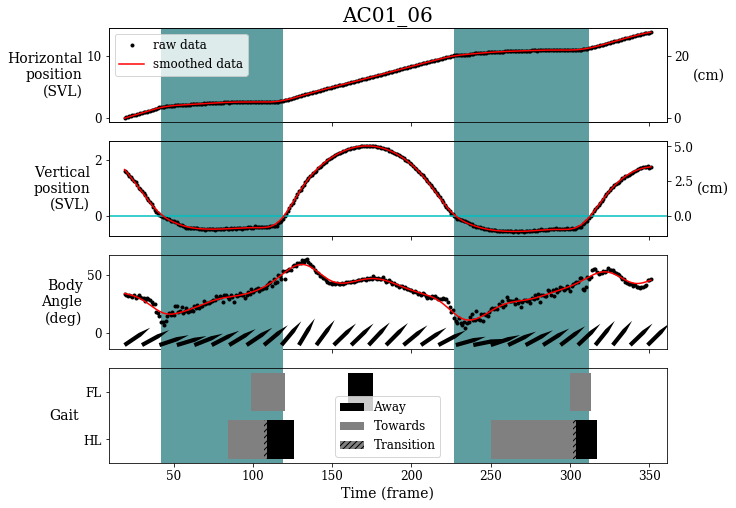

In [72]:
g.graph_all('AC01_06', 'frame', (10, 8), segment=False)

In [146]:
frog = 'AC03_14'

data = g.loadSingleFrog_wsmoothed(frog)
s_mnty = data['s_mnty']
s_mntx = data['s_mntx']
s_mnta = data['s_mnta']
ranges = define_jump_ranges(data)
print(ranges)

{0: {'above': (0, 56)}, 1: {'above': (213, 293), 'below': (56, 213)}, 2: {'below': (293, -1)}}


In [80]:
s_mnty[slice(*ranges[0]['above'])]

array([153.09987666, 146.7098488 , 140.23934617, 133.69415341,
       127.07419989, 120.37645714, 113.59757227, 106.7361638 ,
        99.79472257,  92.78107687,  85.70940004,  78.60075295,
        71.48315537,  64.39117227,  57.36500117,  50.44906833,
        43.69018247,  37.13534144,  30.82932895,  24.81227262,
        19.1173665 ,  13.76898173,   8.78137888])

In [83]:
jmpfit = np.polyfit(s_mntx[slice(*ranges[0]['above'])], s_mnty[slice(*ranges[0]['above'])], 2)

In [85]:
jmpfitpoly = np.poly1d(jmpfit)

In [87]:
jmpfitpoly.deriv().roots

array([-2529.16244606])

In [162]:
def tempexplore(jmpno):
    frog = 'AC03_14'

    data = g.loadSingleFrog_wsmoothed(frog)
    s_mnty = data['s_mnty']
    s_mntx = data['s_mntx']
    s_mnta = data['s_mnta']
    ranges = define_jump_ranges(data)
    
    jmpfit = np.polyfit(s_mntx[slice(*ranges[jmpno]['above'])], s_mnty[slice(*ranges[jmpno]['above'])], 2)
    jmpfitpoly = np.poly1d(jmpfit)
    #print(jmpfitpoly.deriv().roots)
    zerocross = jmpfitpoly.roots
    print(zerocross)
    theinflect = jmpfitpoly.deriv().roots[0]
    
    
    maxrange = np.max(s_mntx[slice(*ranges[jmpno]['above'])])
    minrange = np.min(s_mntx[slice(*ranges[jmpno]['above'])])
    
    print(minrange, maxrange)

    
    if maxrange > theinflect > minrange:
        print('idx @ Max Height = %f' %theinflect)
        print('max Height = %f' %(np.max(s_mnty[slice(*ranges[jmpno]['above'])])))
        print('Fit Height = %f' %jmpfitpoly(theinflect))
        
        #Check - is the actual range available?
        if -1 not in ranges[jmpno]['above']:
        
            print('max Range = %f' %(s_mntx[ranges[jmpno]['above'][1]] - s_mntx[ranges[jmpno]['above'][0]]))
        else: 
            print('max Range = NONE')
        print('Fit Range = %f' %(zerocross[0] - zerocross[1]))
    
    
    plt.plot(s_mntx[slice(*ranges[jmpno]['above'])], jmpfitpoly(s_mntx[slice(*ranges[jmpno]['above'])]), 'k-', label='fit')
    plt.plot(s_mntx[slice(*ranges[jmpno]['above'])], s_mnty[slice(*ranges[jmpno]['above'])], 'r.', label='smoothed data')


[1115.47801684  557.00571881]
551.1341610935583 1114.584464960843
idx @ Max Height = 836.241868
max Height = 125.229337
Fit Height = 124.198067
max Range = 569.051075
Fit Range = 558.472298


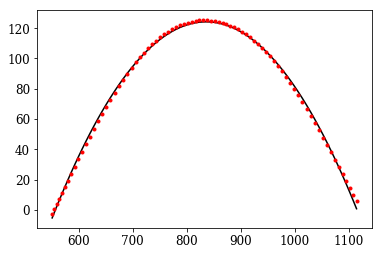

In [163]:
tempexplore(1)

In [98]:
len(s_mnty)

333

In [136]:
3 <= 3.45 <= 77

True

# OK, Lets try and do the velocity metrics now, because the position metrics got very long and complicated

In [7]:
  #########VELOCITIES##############
    #idx of Max Vel
    #frame of max vel
    #Vx at max Vel (px/sec)
    #Vy @ max vel (px/sec)
    #V @ max vel (px/sec)
    #V angle @ max V
    #body angle @ max V

    #avg horizontal velocity above WS (px/sec)
    #avg horizontal velcity below WS AFTER JUMP (px/sec) - like coast velocity - this is before jump + 1
    #avg horizontal velocity total (launch + land coast)
    ### ============== CHECK - DURING PROP/PREP, WHAT VERT/HOR DISTANCE MOVED?

Text(0.5, 0, 'Time (sec)')

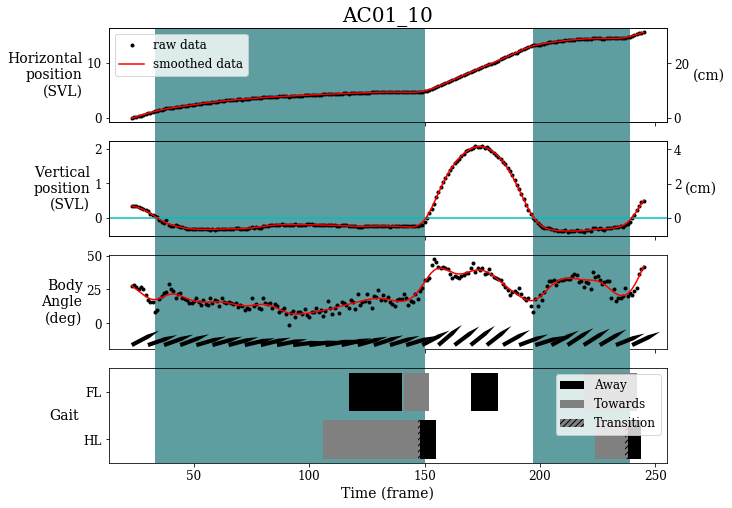

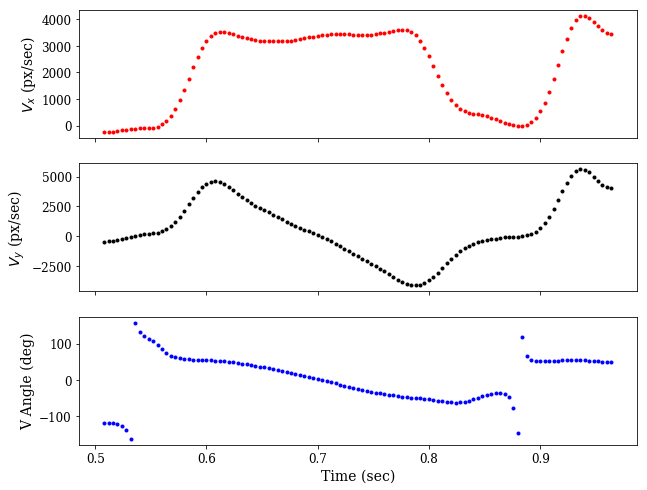

In [5]:
data = g.loadSingleFrog_wsmoothed('AC03_04')

s_mntx = data['s_mntx']
s_mnty = data['s_mnty']


v_smntx=np.gradient(s_mntx, data['time'])
v_smnty= np.gradient(s_mnty, data['time'])
v_angle = np.rad2deg(np.arctan2(v_smnty, v_smntx))


scale = data['frogsize(cm)']

scale = data['frogsize(cm)']

#And plot to see if it looks good
ax2, fig2 = g.graph_all('AC01_10', 'frame', (10, 8), segment=False, clip=False)
fig, ax = plt.subplots(nrows=3, sharex=True, figsize=(10, 8))
ax[0].plot(data['time'], v_smntx, 'r.', label='V_x')
ax[0].set_ylabel('$V_{x}$ (px/sec)')

ax[1].plot(data['time'], v_smnty, 'k.', label='V_y')
ax[1].set_ylabel('$V_{y}$ (px/sec)')
ax[2].plot(data['time'], v_angle, 'b.', label='angle')

ax[2].set_ylabel('V Angle (deg)')
ax[2].set_xlabel('Time (sec)')


In [6]:
#lets get the jump ranges
ranges = define_jump_ranges(data)
no_jumps = len(ranges.keys())

In [7]:
list(ranges[1].values())

[(103, -1), (75, 103)]

In [8]:
import scipy
print(scipy.__version__)
from scipy import signal

1.4.1


dict_keys([0, 1, 2])


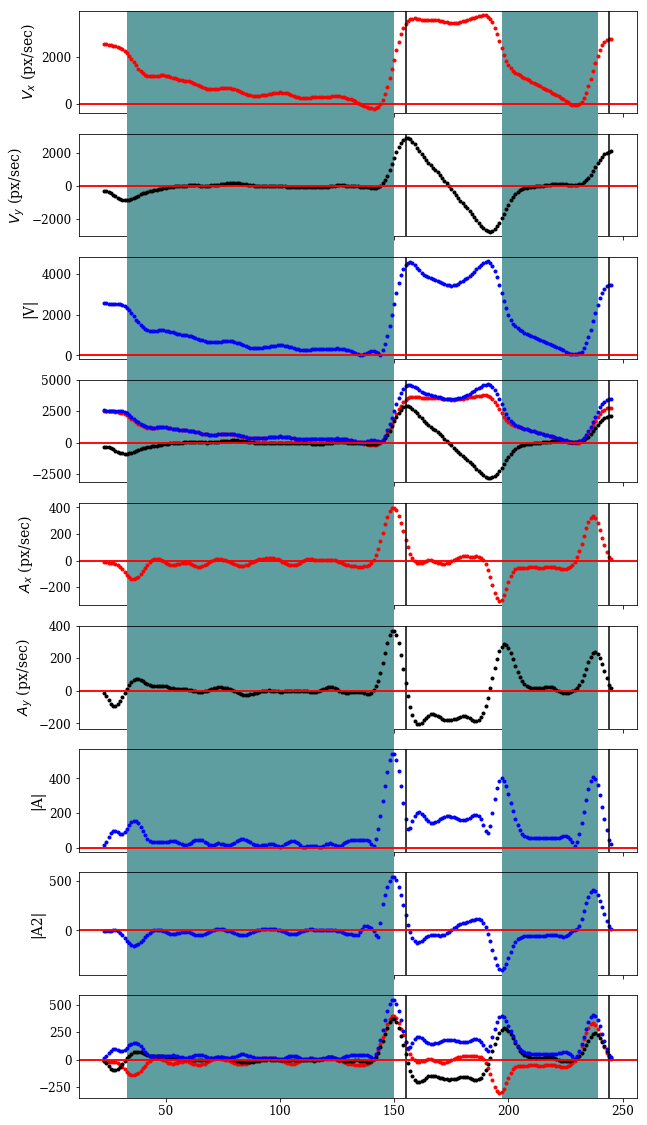

33 197
Jmp No 1
-------------Vx---------------
(array([166]),)
[ 16  43  67  92 126 134 156] (array([26]),) [49]
{'left_bases': array([ 11,  37,  56,  78, 108, 131, 108]), 'right_bases': array([108, 108, 108, 108, 143, 143, 163]), 'prominences': array([  47.89472382,   50.78897605,  141.98556459,   80.31799267,
        200.11442113,    9.30649642, 1093.671934  ])}
-------------Vy---------------
(array([133]),)
[ 29  47  64  93 123] (array([39]),) [62]
{'left_bases': array([ 0,  0, 60, 85,  0]), 'right_bases': array([ 35, 108,  85, 108, 159]), 'prominences': array([  23.43314025,  290.90743215,    5.33070928,  126.95521543,
       3771.54135699])}
-------------|V|---------------
[124 157 158]
[124 158] (array([134]),) [157]
{'left_bases': array([103, 103]), 'right_bases': array([142, 163]), 'prominences': array([1146.48678309, 1147.00564   ])}


197 245
Jmp No 2
-------------Vx---------------
(array([221]),)
-------------Vy---------------
(array([221]),)
[25] (array([199]),) [222]
{'lef

In [139]:
#Idx of max velocity - 
### MUST INCLUDE WATER EXIT
### MAYBE.....inflection point???

data = g.loadSingleFrog_wsmoothed('AC01_10')

s_mntx = data['s_mntx']
s_mnty = data['s_mnty']

ranges = define_jump_ranges(data)
no_jumps = len(ranges.keys())
print(ranges.keys())

v_smntx=np.gradient(s_mntx, data['time'])
v_smnty= np.gradient(s_mnty, data['time'])
v_angle = np.rad2deg(np.arctan2(v_smnty, v_smntx))

v_scalar = np.sqrt(v_smntx**2 + v_smnty**2)


a_smntx=np.gradient(v_smntx, data['frameno'])
a_smnty= np.gradient(v_smnty, data['frameno'])
a_angle = np.rad2deg(np.arctan2(a_smnty, a_smntx))
a_2 = np.gradient(v_scalar, data['frameno'])

a_scalar = np.sqrt(a_smntx**2 + a_smnty**2)

fig, ax = plt.subplots(nrows=9, sharex=True, figsize=(10, 20))
ax[0].plot(data['frameno'], v_smntx, 'r.', label='V_x')
ax[0].set_ylabel('$V_{x}$ (px/sec)')

ax[1].plot(data['frameno'], v_smnty, 'k.', label='V_y')
ax[1].set_ylabel('$V_{y}$ (px/sec)')

ax[2].plot(data['frameno'], v_scalar, 'b.', label='V')
ax[2].set_ylabel('|V|')
ax[2].set_xlabel('frame')

ax[3].plot(data['frameno'], v_smntx, 'r.', label='V_x')
ax[3].plot(data['frameno'], v_smnty, 'k.', label='V_y')
ax[3].plot(data['frameno'], v_scalar, 'b.', label='V')

ax[4].plot(data['frameno'], a_smntx, 'r.', label='A_x')
ax[4].set_ylabel('$A_{x}$ (px/sec)')

ax[5].plot(data['frameno'], a_smnty, 'k.', label='A_y')
ax[5].set_ylabel('$A_{y}$ (px/sec)')

ax[6].plot(data['frameno'], a_scalar, 'b.', label='A')
ax[6].set_ylabel('|A|')
ax[6].set_xlabel('frame')

ax[7].plot(data['frameno'], a_2, 'b.', label='A')
ax[7].set_ylabel('|A2|')
ax[7].set_xlabel('frame')

ax[8].plot(data['frameno'], a_smntx, 'r.', label='A_x')
ax[8].plot(data['frameno'], a_smnty, 'k.', label='A_y')
ax[8].plot(data['frameno'], a_scalar, 'b.', label='A')




### where is HL_a
for prop in data['HL_a']:
    st, dur = prop
    for axs in ax:
        axs.axvline(st + dur, color='black')
        axs.axhline(0, color='red')
    


###############################
##Underwater graphing
###############################
water = [0] + list(data['watercontactIdx'][0]) + [len(data['frameno']) - 1]
#print(s_mnty[water])
test = [(water[i], water[i+1]) for i in range(len(water) - 1) if s_mnty[int(np.mean([water[i], water[i+1]]))] < 0]
thetime = data['frameno']
ftt = 1

for idx, tax in enumerate(ax):             
    for o in test:
        if idx == 0:
            y_max = 1
            y_min = 0
        else:
            y_min = 0
            y_max = 1.2
        if o[0] == 0:
            start = np.array(thetime)[o[0]] - 10*ftt
        else:
            start = np.array(thetime)[o[0]] 
        if o[1] == len(s_mnty) - 1:
            end = np.array(thetime)[o[1]] + 10 *ftt
        else:
            end = np.array(thetime)[o[1]]
                                         
        tax.axvspan(start, end, ymin = y_min, ymax = y_max, facecolor='cadetblue', alpha = 1, zorder = 0, clip_on=False)



plt.show()

for jmp in range(no_jumps):
    if 'above' in ranges[jmp]:
        if 0 not in ranges[jmp]['above']:
            start = None
            end = None
            for sec in ranges[jmp].keys():
                tmpstart, tmpend = ranges[jmp][sec]
                if tmpend == -1:
                    tmpend = len(v_smntx)- 1
                if start is None:
                    start = tmpstart
                elif tmpstart < start:
                    start = tmpstart
                if end is None:
                    end = tmpend
                elif tmpend > end:
                    end = tmpend
            
            print(data['frameno'][start], data['frameno'][end]) 
            
            #plt.plot(data['time'][slice(*ranges[jmp]['above'])], a_smnty[slice(*ranges[jmp]['above'])], 'k-')
            #plt.show()
            print('Jmp No %d' %jmp)
            print('-------------Vx---------------')
            peak, k = signal.find_peaks(v_smntx[start:end], prominence=1)
            #peak is now the index in this sliced area of the peak
            #now need to find the overall index
            print(np.where(v_smntx == np.max(v_smntx[start:end])))
            if len(peak) > 0:
                fullidx = np.where(v_smntx == v_smntx[start:end][peak[0]])
                print(peak, fullidx, data['frameno'][fullidx])
                print(k)

            print('-------------Vy---------------')
            peak, k = signal.find_peaks(v_smnty[start:end],prominence=1)
            #peak is now the index in this sliced area of the peak
            #now need to find the overall index
            print(np.where(v_smnty == np.max(v_smnty[start:end])))

            if len(peak) > 0:
                fullidx = np.where(v_smnty == v_smnty[start:end][peak[0]])
                print(peak, fullidx, data['frameno'][fullidx])
                print(k)

            print('-------------|V|---------------')
            peak, k = signal.find_peaks(v_scalar[start:end], prominence=500)
            #peak is now the index in this sliced area of the peak
            #now need to find the overall index
            print(np.argsort(v_scalar[start:end])[-3:])

            if len(peak) > 0:
                fullidx = np.where(v_scalar == v_scalar[start:end][peak[0]])
                print(peak, fullidx, data['frameno'][fullidx])
                print(k)
            print('\n')

In [124]:
peak, k = signal.find_peaks(v_scalar, threshold=.01)
peak

array([301])

In [117]:
data['HL_a']

[(109, 17), (304, 13)]

In [96]:
print(v_scalar[40], v_scalar[41], v_scalar[42])
print(v_scalar[90], v_scalar[91], v_scalar[92])
print(v_scalar[178], v_scalar[179], v_scalar[180])
print(v_scalar[215], v_scalar[216], v_scalar[217])

5814.122354666914 5829.937480033459 5810.732238092109
3961.9345906700937 3964.67942292351 3958.0462290586524
347.38434805905786 349.7711299243321 346.4245262602716
6093.553280906857 6104.268346490769 6085.307347458802


In [12]:
ranges

{0: {'above': (0, 23)},
 1: {'above': (100, 208), 'below': (23, 100)},
 2: {'above': (293, -1), 'below': (208, 293)}}

In [123]:
data = g.loadSingleFrog_wsmoothed('AC01_10')

s_mntx = data['s_mntx']
s_mnty = data['s_mnty']

ranges = define_jump_ranges(data)
no_jumps = len(ranges.keys())
print(ranges.keys())

v_smntx=np.gradient(s_mntx, data['time'])
v_smnty= np.gradient(s_mnty, data['time'])
v_angle = np.rad2deg(np.arctan2(v_smnty, v_smntx))

v_total = np.sqrt(v_smntx**2 + v_smnty**2)


for jmp in range(no_jumps):
    
    jmp_dict = ranges[jmp]

    eachJmpDict = {}
    print(jmp)
    
    
    #Idx of max velocity - 
    ### MUST INCLUDE WATER EXIT
    ### MAYBE.....inflection point???
    if 'above' in ranges[jmp]:
        if 0 not in ranges[jmp]['above']:
            start = None
            end = None
            for sec in ranges[jmp].keys():
                tmpstart, tmpend = ranges[jmp][sec]
                if tmpend == -1:
                    tmpend = len(v_smntx)- 1
                if start is None:
                    start = tmpstart
                elif tmpstart < start:
                    start = tmpstart
                if end is None:
                    end = tmpend
                elif tmpend > end:
                    end = tmpend
            #MaxVelIdx = np.where(v_total == np.max(v_total[start:end]))
            print(data['frameno'][start], data['frameno'][end])
            peak, k = signal.find_peaks(v_total[start:end], prominence=data['fps'])
            print(peak)
            if len(peak) > 0:
                fullidx = np.where(v_total == v_total[start:end][peak[0]])

                MaxVelIdx = np.where(v_total == v_total[start:end][peak[0]])[0][0]
                print('MaxVelIdx:', MaxVelIdx)
            else:
                MaxVelIdx = None
                MaxVelFr = None
                MaxVx = None
                MaxVy = None
                MaxV = None
                MaxVa = None
                BAatMaxV = None
                AvgHorVelAbove = None
                break

            #frame of max velocity
            MaxVelFr = data['frameno'][MaxVelIdx]
            print('MaxVelFrame: %d' %MaxVelFr)

            #Vx @ Max velocity (px/sec)
            MaxVx = v_smntx[MaxVelIdx]
            print('Vx @ Max V: %f' %MaxVx)
            #Vy @ Max velocity (px/sec)
            MaxVy = v_smnty[MaxVelIdx]
            print('Vy @ Max V: %f' %MaxVy)
            #V @ max velocity (px/sec)
            MaxV = np.sqrt(MaxVx**2 + MaxVy**2)
            print('V @ Max V: %f' %MaxV)
            #V angle @ Max velocity (deg)
            MaxVa = v_angle[MaxVelIdx]
            print('V angle @ Max V: %f' %MaxVa)
            #BA @ max veloctity
            BAatMaxV = data['s_mnta'][MaxVelIdx]
            print('BA @ Max V: %f' %BAatMaxV)
          

            if -1 not in ranges[jmp]['above']:
                #Avg horizontal velocity above water
                AvgHorVelAbove = np.mean(v_smntx[slice(*ranges[jmp]['above'])])
                print('Above Horizontal Velocity - Above Water: %f' %AvgHorVelAbove)
            else:
                AvgHorVelAbove = None
        else:
            MaxVelIdx = None
            MaxVelFr = None
            MaxVx = None
            MaxVy = None
            MaxV = None
            MaxVa = None
            BAatMaxV = None
            AvgHorVelAbove = None
    else:
        MaxVelIdx = None
        MaxVelFr = None
        MaxVx = None
        MaxVy = None
        MaxV = None
        MaxVa = None
        BAatMaxV = None
        AvgHorVelAbove = None
        
    
    if jmp + 1 <= no_jumps - 1:
        if 'below' in ranges[jmp+1]:
            if 0 not in ranges[jmp+1]['below'] and -1 not in ranges[jmp+1]['below']:
                jmp_dict2 = ranges[jmp+1]
                
                #Avg horizontal velocity below water (after jump)
                AvgHorVelBelow_after = np.mean(v_smntx[slice(*ranges[jmp+1]['below'])])
                print('Above Horizontal Velocity - Below Water - After: %f' %AvgHorVelBelow_after)
            else:
                AvgHorVelBelow_after = None
        else:
            AvgHorVelBelow_after = None
    else:
        AvgHorVelBelow_after = None

    
    if AvgHorVelAbove is not None and AvgHorVelBelow_after is not None:
        #Avg horizontal velocity entire jump 
        start = np.min(list(ranges[jmp]['above']))
        end = np.max(list(ranges[jmp+1]['below']))
        AvgHorVelTotal = np.mean(v_smntx[start:end])
        print('Above Horizontal Velocity - Total: %f' %AvgHorVelTotal)
    else:
        AvgHorVelTotal = None

dict_keys([0, 1, 2])
0
Above Horizontal Velocity - Below Water - After: 626.784364
1
33 197
[124 158]
MaxVelIdx: 134
MaxVelFrame: 157
Vx @ Max V: 3598.456519
Vy @ Max V: 2843.534630
V @ Max V: 4586.346968
V angle @ Max V: 38.316127
BA @ Max V: 40.758666
Above Horizontal Velocity - Above Water: 3429.849436
Above Horizontal Velocity - Below Water - After: 811.871963
Above Horizontal Velocity - Total: 2194.399393
2
197 245
[]


In [140]:
ranges

{0: {'above': (0, 10)},
 1: {'above': (127, 174), 'below': (10, 127)},
 2: {'above': (216, -1), 'below': (174, 216)}}

In [143]:
if 'below' in ranges[0] and 0 not in ranges[0]['below']:
    print('22')

In [134]:
def get_velocity_stats_old_dict(data):
    s_mntx = data['s_mntx']
    s_mnty = data['s_mnty']

    ranges = define_jump_ranges(data)
    no_jumps = len(ranges.keys())
    print(ranges.keys())
    
    v_smntx=np.gradient(s_mntx, data['time'])
    v_smnty= np.gradient(s_mnty, data['time'])
    v_angle = np.rad2deg(np.arctan2(v_smnty, v_smntx))

    v_total = np.sqrt(v_smntx**2 + v_smnty**2)

    frog_dict = {}

    for jmp in range(no_jumps):
        
        eachJmpDict = {}
        
        jmp_dict = ranges[jmp]

        eachJmpDict = {}
        #print(jmp)


        #Idx of max velocity - 
        ### MUST INCLUDE WATER EXIT
        ### MAYBE.....inflection point???
        if 'above' in ranges[jmp]:
            if 0 not in ranges[jmp]['above']:
                start = None
                end = None
                for sec in ranges[jmp].keys():
                    tmpstart, tmpend = ranges[jmp][sec]
                    if tmpend == -1:
                        tmpend = len(v_smntx)- 1
                    if start is None:
                        start = tmpstart
                    elif tmpstart < start:
                        start = tmpstart
                    if end is None:
                        end = tmpend
                    elif tmpend > end:
                        end = tmpend
                #MaxVelIdx = np.where(v_total == np.max(v_total[start:end]))[0][0]
                peak, k = signal.find_peaks(v_total[start:end], prominence=data['fps'])
                if len(peak) > 0:
                    MaxVelIdx = np.where(v_total == v_total[start:end][peak[0]])[0][0]
                    print('MaxVelIdx:', MaxVelIdx)
#                 else:
#                     MaxVelIdx = None
#                     MaxVelFr = None
#                     MaxVx = None
#                     MaxVy = None
#                     MaxV = None
#                     MaxVa = None
#                     BAatMaxV = None
#                     AvgHorVelAbove = None
                    
                
                

                    #frame of max velocity
                    MaxVelFr = data['frameno'][MaxVelIdx]
                    print('MaxVelFrame: %d' %MaxVelFr)

                    #Vx @ Max velocity (px/sec)
                    MaxVx = v_smntx[MaxVelIdx]
                    print('Vx @ Max V: %f' %MaxVx)
                    #Vy @ Max velocity (px/sec)
                    MaxVy = v_smnty[MaxVelIdx]
                    print('Vy @ Max V: %f' %MaxVy)
                    #V @ max velocity (px/sec)
                    MaxV = np.sqrt(MaxVx**2 + MaxVy**2)
                    print('V @ Max V: %f' %MaxV)
                    #V angle @ Max velocity (deg)
                    MaxVa = v_angle[MaxVelIdx]
                    print('V angle @ Max V: %f' %MaxVa)
                    #BA @ max veloctity
                    BAatMaxV = data['s_mnta'][MaxVelIdx]
                    print('BA @ Max V: %f' %BAatMaxV)
                    
                    
                    if -1 not in ranges[jmp]['above']:
                        #Avg horizontal velocity above water
                        AvgHorVelAbove = np.mean(v_smntx[slice(*ranges[jmp]['above'])])
                        print('Above Horizontal Velocity - Above Water: %f' %AvgHorVelAbove)
                    else:
                        AvgHorVelAbove = None
                    
                else:
                    MaxVelIdx = None
                    MaxVelFr = None
                    MaxVx = None
                    MaxVy = None
                    MaxV = None
                    MaxVa = None
                    BAatMaxV = None
                    AvgHorVelAbove = None


            else:
                MaxVelIdx = None
                MaxVelFr = None
                MaxVx = None
                MaxVy = None
                MaxV = None
                MaxVa = None
                BAatMaxV = None
                AvgHorVelAbove = None
        else:
            MaxVelIdx = None
            MaxVelFr = None
            MaxVx = None
            MaxVy = None
            MaxV = None
            MaxVa = None
            BAatMaxV = None
            AvgHorVelAbove = None


        if jmp + 1 <= no_jumps - 1:
            if 'below' in ranges[jmp+1]:
                if 0 not in ranges[jmp+1]['below'] and -1 not in ranges[jmp+1]['below']:
                    jmp_dict2 = ranges[jmp+1]

                    #Avg horizontal velocity below water (after jump)
                    AvgHorVelBelow_after = np.mean(v_smntx[slice(*ranges[jmp+1]['below'])])
                    print('Above Horizontal Velocity - Below Water - After: %f' %AvgHorVelBelow_after)
                else:
                    AvgHorVelBelow_after = None
            else:
                AvgHorVelBelow_after = None
        else:
            AvgHorVelBelow_after = None


        if AvgHorVelAbove is not None and AvgHorVelBelow_after is not None:
            #Avg horizontal velocity entire jump 
            start = np.min(list(ranges[jmp]['above']))
            end = np.max(list(ranges[jmp+1]['below']))
            AvgHorVelTotal = np.mean(v_smntx[start:end])
            print('Above Horizontal Velocity - Total: %f' %AvgHorVelTotal)
        else:
            AvgHorVelTotal = None    
            
        eachJmpDict = {'MaxVelIdx':MaxVelIdx, 
                       'MaxVelFr':MaxVelFr,
                       'MaxVx':MaxVx,
                       'MaxVy':MaxVy,
                       'MaxV':MaxV,
                       'MaxVa':MaxVa, 
                       'BAatMaxV':BAatMaxV,
                       'AvgHorVelAbove':AvgHorVelAbove,
                       
                       'AvgHorVelBelow_after':AvgHorVelBelow_after,
                       'AvgHorVelTotal':AvgHorVelTotal}
        print(jmp)
        frog_dict[jmp] = eachJmpDict
    return frog_dict

In [135]:
Velsprdsht = pd.DataFrame(columns = ['ID', 'jmpNo', 'MaxVelIdx', 'MaxVelFr', 
                                     'MaxVx', 'MaxVy', 'MaxV', 'MaxVa', 
                                     'BAatMaxV', 'AvgHorVelAbove', 
                                     'AvgHorVelBelow_after', 'AvgHorVelTotal'])

In [136]:
i = 0
for frog in full_list_seq:
    print(frog)
    data = g.loadSingleFrog_wsmoothed(frog)

    frog_all_jmps = get_velocity_stats_old_dict(data)
    print(frog_all_jmps.keys())
    for jmp in frog_all_jmps.keys():
        print(jmp)
        newrow = frog_all_jmps[jmp]
        newrow['ID'] = frog
        newrow['jmpNo'] = jmp + 1
        #print(newrow.keys())
        Velsprdsht.loc[i] = newrow
        i+=1
        
        

AC01_04
dict_keys([0, 1])
Above Horizontal Velocity - Below Water - After: 401.121846
0
MaxVelIdx: 152
MaxVelFrame: 185
Vx @ Max V: 3399.719278
Vy @ Max V: 4131.829310
V @ Max V: 5350.710664
V angle @ Max V: 50.552038
BA @ Max V: 53.759160
1
dict_keys([0, 1])
0
1
AC01_05
dict_keys([0, 1])
MaxVelIdx: 20
MaxVelFrame: 83
Vx @ Max V: 3175.371269
Vy @ Max V: 4569.827467
V @ Max V: 5564.737709
V angle @ Max V: 55.206270
BA @ Max V: 57.228400
Above Horizontal Velocity - Above Water: 2982.188438
Above Horizontal Velocity - Below Water - After: 757.954707
Above Horizontal Velocity - Total: 2192.000139
0
MaxVelIdx: 171
MaxVelFrame: 234
Vx @ Max V: 3192.739478
Vy @ Max V: 5071.767374
V @ Max V: 5993.030091
V angle @ Max V: 57.809084
BA @ Max V: 61.706311
1
dict_keys([0, 1])
0
1
AC01_06
dict_keys([0, 1, 2])
Above Horizontal Velocity - Below Water - After: 679.465425
0
MaxVelIdx: 109
MaxVelFrame: 128
Vx @ Max V: 3415.465507
Vy @ Max V: 4274.838932
V @ Max V: 5471.713856
V angle @ Max V: 51.376215
B

In [119]:
Velsprdsht

,ID,jmpNo,MaxVelIdx,MaxVelFr,MaxVx,MaxVy,MaxV,MaxVa,BAatMaxV,AvgHorVelAbove,AvgHorVelBelow_after,AvgHorVelTotal
0,AC01_04,1,None,None,None,None,None,None,None,None,401.122,None
1,AC01_04,2,152,185,3399.72,4131.83,5350.71,50.552,53.7592,None,None,None
2,AC01_05,1,20,83,3175.37,4569.83,5564.74,55.2063,57.2284,2982.19,757.955,2192
3,AC01_05,2,171,234,3192.74,5071.77,5993.03,57.8091,61.7063,None,None,None
4,AC01_06,1,None,None,None,None,None,None,None,None,679.465,None
5,AC01_06,2,109,128,3415.47,4274.84,5471.71,51.3762,58.7275,3062.33,678.612,2012.51
6,AC01_06,3,301,320,3265.93,3542.65,4818.36,47.3274,52.7069,None,None,None
7,AC01_10,1,None,None,None,None,None,None,None,None,626.784,None
8,AC01_10,2,134,157,3598.46,2843.53,4586.35,38.3161,40.7587,3429.85,811.872,2194.4
9,AC03_04,1,25,152,3464.49,4599.31,5758.15,53.0107,56.2423,3300.39,629.052,2388.22


In [137]:
Velsprdsht.to_csv('Automated_OldJmpVelocityMetrics_tmp2.csv', index=False, na_rep= "" )